# Stock close price prediction model1
##### reference : http://www.jakob-aungiers.com/articles/a/LSTM-Neural-Network-for-Time-Series-Prediction
---


## 1.Load data, convert data to time series

In [1]:
import os
import time
import warnings
import numpy as np
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy Numpy warnings

def load_data(filename, seq_len, normalise_window):
    f = open(filename, 'rb').read()
    data = f.decode().split('\n')

    #定義一段time series長度
    sequence_length = seq_len + 1 
    result = []
    
    #把原本只有一維的 time series 從t=0開始擴展成;t=0到t=seq_len為第一筆data, t=1到t=seq_len+1...以此類推
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    #每個 window 都對第一個點 normalize
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    #切分 training set / testing set
    row = round(0.78 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

Using TensorFlow backend.


In [2]:
seq_len = 50
X_train, y_train, X_test, y_test = load_data('2618.TW.csv', seq_len, True)
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (912, 50, 1)
y_train shape (912,)
X_test shape (257, 50, 1)
y_test shape (257,)


In [3]:
print(type(X_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


---
## 2.Build RNN model

The way Keras LSTM layers work is by taking in a numpy array of 3 dimensions (N, W, F) 
where N is the number of training sequences, 
W is the sequence length 
and F is the number of features of each sequence.

In [4]:
def build_model_1(layers):
    
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True)) #return_sequence?
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))
    
    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    
    #model.compile
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    return model


In [5]:
model = build_model_1([1, 50, 100, 1])

> Compilation Time :  0.031075000762939453


---
## 3.Train model

In [6]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    nb_epoch=1, #If this data had less structure to it, a large number of epochs would be required
    validation_split=0.05)

Train on 866 samples, validate on 46 samples
Epoch 1/1
866/866 [==============================] - 4s - loss: 0.0085 - val_loss: 0.0039


---
## 4.Make prediction

In [7]:
import time
import matplotlib.pyplot as plt

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend(loc='upper left')
    plt.legend()
    plt.show()

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.legend(loc='upper left')
    plt.show()
    
def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted


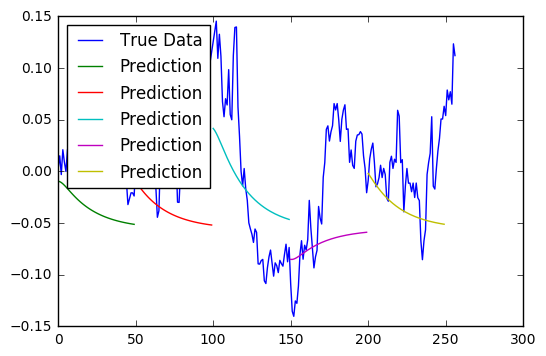

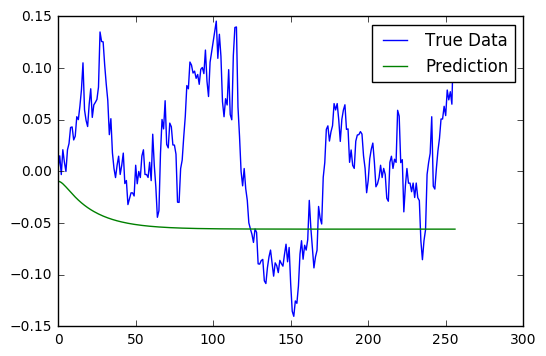

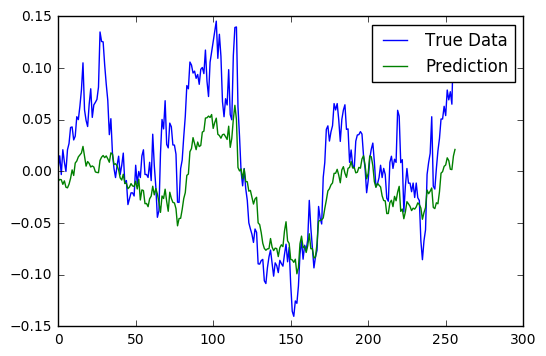

In [8]:
prediction1 = predict_sequences_multiple(model, X_test, seq_len, 50)
prediction2 = predict_sequence_full(model, X_test, seq_len)
prediction3 = predict_point_by_point(model, X_test)
plot_results_multiple(prediction1, y_test, 50)
plot_results(prediction2, y_test)
plot_results(prediction3, y_test)

In [9]:
len(y_test)

257

In [10]:
prediction4 = predict_sequences_multiple(model, X_test[7:], 50, 50)

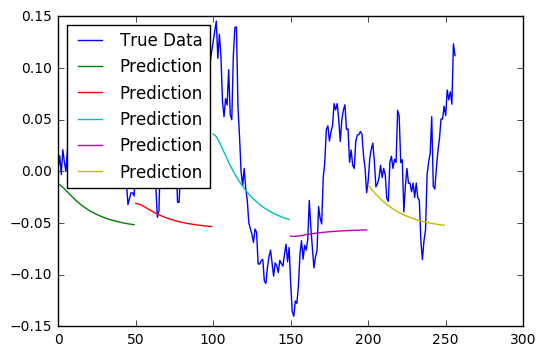

In [11]:
plot_results_multiple(prediction4, y_test, 50)